<a href="https://colab.research.google.com/github/khalidashani/MscProject/blob/main/DataManagement_Project2_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

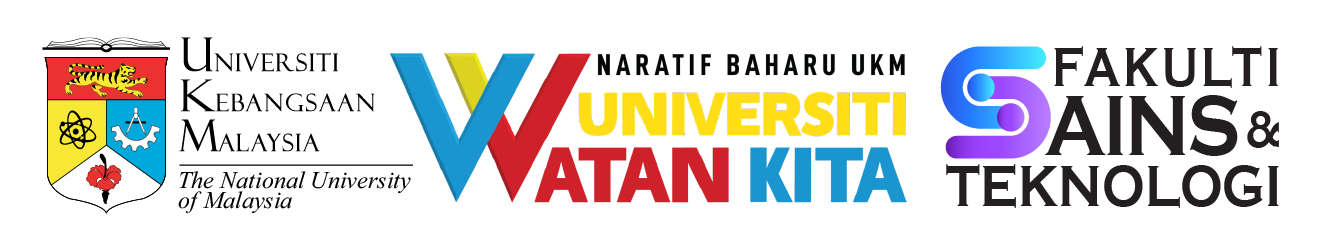

# Project 2
## **STQD6324 Data Management Semester 2 2025/2026**
*Muhammad Khalid Bin Noor Ashani (P146854)*

# **Uncovering Operational Insights in U.S. Airline Performance: A Big Data Approach Using Hive and Python**

---

## **Table of Contents**

1. [**Introduction**](#introduction)  
2. [**Problem Statement**](#problem-statement)  
3. [**Linking Virtual Machine and Enviroment Setup**](#methodology-and-implementation)  
4. [**Discussion and Findings**](#discussion-and-findings)  
5. [**Conclusion**](#conclusion)  

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Introduction** <a name='intro'></a>

The frustration of a delayed or cancelled flight is a familiar story, but behind each disruption lies a complex web of operational data. This project undertakes a technical deep dive into such data to move beyond anecdotes and uncover the patterns that drive airline performance.

Our analysis is based on the Airline On-Time Performance dataset for the year 2008, a comprehensive and large-scale dataset from Kaggle. Given its volume and complexity, the project adopts a big data approach to ensure efficient processing and insightful analysis.

Processing such a large dataset on a local machine can be challenging due to resource constraints and performance limitations. To address this, the analysis is conducted within a virtual machine (VM) environment pre-configured with big data tools. The VM provides the necessary infrastructure to simulate a distributed computing setup, enabling us to run Hive queries and process data efficiently—something that would be difficult or infeasible on a standard local system.

We employ a two-stage methodology:

1. Data processing and extraction using Apache Hive to filter, aggregate, and
query large volumes of flight records efficiently.

2. Exploratory analMZysis and visualization using Python libraries such as Pandas, Matplotlib, and Seaborn to interpret the Hive outputs and derive meaningful insights.

This combination of tools enables us to systematically address the project’s core questions:

*   What are the patterns of flight delays by time, day, and season?
*   Which factors most significantly contribute to delays?
*   What are the key reasons for cancellations, and how are they distributed across airlines, airports, or time periods?
*   Which routes and carriers consistently exhibit poor performance?

### **Problem Statement** <a name='problem_statement'></a>

Flight delays and cancellations represent a persistent and costly challenge for the aviation industry, creating significant operational burdens for airlines and frustrating travel experiences for passengers. The sheer volume of flight data generated daily makes it difficult to move from simply acknowledging these disruptions to truly understanding their root causes and deriving actionable insights. Traditional data analysis tools often fall short when handling datasets of this scale, limiting the ability to extract meaningful intelligence.

This project tackles the big data challenge head-on. By leveraging the power of Apache Hive, we efficiently query and aggregate the comprehensive 2008 Airline On-Time Performance dataset. The goal is to transform millions of flight records into focused summaries that answer critical business questions with a level of statistical confidence enabled by large-scale analysis.

1. **Uncover Delay Patterns**: Identify which times of day, days of the week, and months or seasons consistently exhibit the lowest average delays and better on-time performance.

2. **Quantify Delay Factors**: Determine and rank the top 3–5 factors contributing to flight delays, quantifying their impact in terms of average delay minutes and their percentage contribution to total delays.

3. **Analyze Cancellations**: Identify the primary reasons for flight Identify the primary reasons for flight cancellations and assess whether these cancellations correlate with specific airlines, airports, or time periods.

4. **Pinpoint Problematic Routes**: Identify specific routes Identify routes (origin–destination pairs), carriers, or flight numbers that consistently demonstrate poor performance, and analyze the contributing factors behind these issues.

Ultimately, this project aims to convert massive, raw operational data into actionable insights, enabling the aviation industry to better manage, anticipate, and mitigate service disruptions.

### **Linking Virtual Machine and Enviroment Setup** <a name='methodology-and-implementation'></a>

#### **Linking Virtual Machine and Enviroment Setup** <a name='virtual'></a>

The following methodology outlines the technical steps undertaken to set up the analysis environment and process the large-scale 2008 Airline On-Time Performance dataset using Apache Hive and Python. Due to the dataset’s size, additional handling was required to upload and integrate it into Hive via HDFS.


The analysis was conducted using a Virtual Machine (VM) hosted on Oracle VirtualBox, which provided a pre-configured sandbox environment with a full Hadoop ecosystem, including Hive, HDFS, and YARN.

On the local machine, a dedicated Conda virtual environment was created to isolate the required packages:


In [ ]:
conda create -n airline_env python=3.8 -y
conda activate airline_env
conda install pandas numpy matplotlib seaborn scikit-learn jupyter
pip install pyhive thrift thrift-sasl pure-sasl impyla
conda install -c conda-forge sasl jupyterlab openpyxl plotly


This environment included all Python libraries needed for data processing, visualization, and connection to Hive.


Due to the large size of the 2008 dataset, uploading it directly via Ambari was not feasible. Instead, the dataset was transferred into HDFS using PuTTY and SCP, as follows:


In [4]:
# 1. Open PuTTY and connect to the VM:
  Host: 127.0.0.1
  Port: 2222
  User: maria_dev

#2. Upload the dataset from the local system to the VM (Use pscp or a file transfer client like WinSCP to copy the file):
pscp -P 2222 C:\path\to\2008.csv maria_dev@127.0.0.1:/home/maria_dev/

#3. Move the file into HDFS via SSH:
hdfs dfs -mkdir /user/maria_dev/input
hdfs dfs -put 2008.csv /user/maria_dev/input/

#4. Create an external Hive table pointing to the HDFS location:
CREATE EXTERNAL TABLE flights_2008 (
  Year INT, Month INT, DayofMonth INT, DayOfWeek INT, DepTime INT, CRSDepTime INT,
  ArrTime INT, CRSArrTime INT, UniqueCarrier STRING, FlightNum STRING,
  TailNum STRING, ActualElapsedTime INT, CRSElapsedTime INT, AirTime INT,
  ArrDelay INT, DepDelay INT, Origin STRING, Dest STRING, Distance INT,
  TaxiIn INT, TaxiOut INT, Cancelled INT, CancellationCode STRING,
  Diverted INT, CarrierDelay INT, WeatherDelay INT, NASDelay INT,
  SecurityDelay INT, LateAircraftDelay INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/user/maria_dev/input/';


IndentationError: unexpected indent (ipython-input-4-964634082.py, line 2)

This approach allowed the large dataset to be processed without relying on Ambari, which has file size upload limitations.

To interact with the Hive database from the local Jupyter Notebook environment, an SSH tunnel was created:

In [ ]:
ssh -L 10000:localhost:10000 maria_dev@127.0.0.1 -p 2222


This command securely forwarded traffic from local port 10000 to Hive running inside the VM.

After setting up the SSH tunnel and activating the environment:


In [ ]:
conda activate airline_env
start jupyter notebook

This launched the Jupyter interface in the browser. From within the notebook, Hive queries were executed using the impala.dbapi module:


In [ ]:
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

The analysis followed a two-stage approach:

* Stage 1 (Hive): Data aggregation and filtering using Hive queries (e.g., average delays, top delay factors).

* Stage 2 (Python): Visualization and exploratory data analysis using Pandas, Seaborn, and Matplotlib.

This methodology enabled scalable, efficient processing of a large dataset within a reproducible and modular setup.

#### **Delay Patterns (Task 1)** <a name='task1'></a>

In [ ]:
conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='airline',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

cursor.execute("SELECT COUNT(*) FROM `2008`")
print(cursor.fetchall())

In [ ]:
query = """
SELECT time_of_day, AVG(ArrDelay) AS avg_arrival_delay
FROM (
    SELECT
      CASE
        WHEN CRSDepTime BETWEEN 0 AND 459 THEN 'Night'
        WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
        WHEN CRSDepTime BETWEEN 1200 AND 1759 THEN 'Afternoon'
        WHEN CRSDepTime BETWEEN 1800 AND 2359 THEN 'Evening'
        ELSE 'Unknown'
      END AS time_of_day,
      ArrDelay
    FROM `2008`
    WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
) AS derived
GROUP BY time_of_day
ORDER BY avg_arrival_delay
"""

cursor.execute(query)
df = pd.DataFrame(cursor.fetchall(), columns=["Time of Day", "Avg Arrival Delay"])
df

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df, x="Time of Day", y="Avg Arrival Delay")
plt.title("Average Arrival Delay by Time of Day")
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("Time of Day")
plt.show()

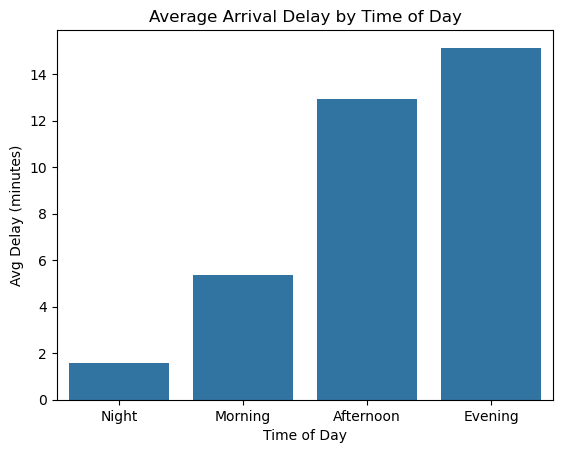

In [ ]:
query = """
SELECT DayOfWeek, AVG(ArrDelay) AS avg_arrival_delay
FROM `2008`
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY DayOfWeek
ORDER BY DayOfWeek
"""

cursor.execute(query)
df_day = pd.DataFrame(cursor.fetchall(), columns=["DayOfWeek", "Avg Arrival Delay"])

# Map DayOfWeek to actual weekday names
day_map = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
    5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}
df_day["Day"] = df_day["DayOfWeek"].map(day_map)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_day, x="Day", y="Avg Arrival Delay")
plt.title("Average Arrival Delay by Day of the Week")
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

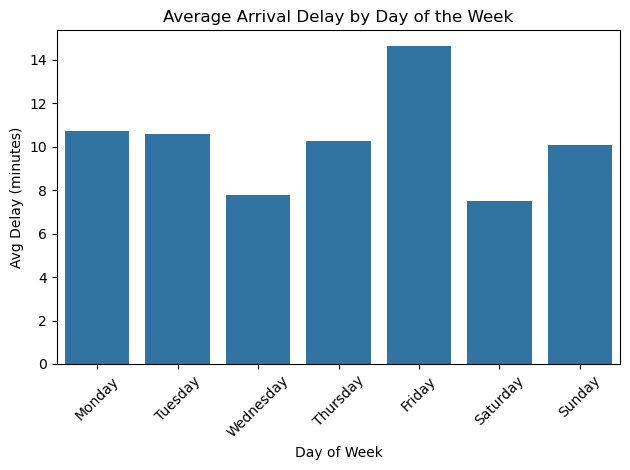

In [ ]:
query = """
SELECT Month, AVG(ArrDelay) AS avg_arrival_delay
FROM `2008`
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY Month
ORDER BY Month
"""

cursor.execute(query)
df_month = pd.DataFrame(cursor.fetchall(), columns=["Month", "Avg Arrival Delay"])

month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_month["MonthName"] = df_month["Month"].map(month_map)

sns.barplot(data=df_month, x="MonthName", y="Avg Arrival Delay")
plt.title("Average Arrival Delay by Month")
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

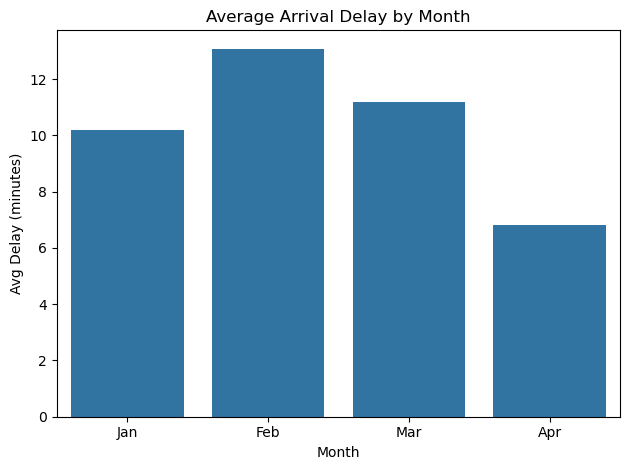

#### **Delay Factors (Task 2)** <a name='task2'></a>

In [ ]:
query = """
SELECT
  SUM(CarrierDelay) AS carrier_delay,
  SUM(WeatherDelay) AS weather_delay,
  SUM(NASDelay) AS nas_delay,
  SUM(SecurityDelay) AS security_delay,
  SUM(LateAircraftDelay) AS late_aircraft_delay
FROM `2008`
WHERE Cancelled = 0
"""
cursor.execute(query)
row = cursor.fetchone()

# Convert to DataFrame
df_delay_factors = pd.DataFrame({
    "Factor": ["Carrier", "Weather", "NAS", "Security", "Late Aircraft"],
    "Total Delay (mins)": row
})

total_delay = df_delay_factors["Total Delay (mins)"].sum()
df_delay_factors["% of Total Delay"] = (
    df_delay_factors["Total Delay (mins)"] / total_delay * 100
).round(2)

sns.barplot(data=df_delay_factors, x="Factor", y="Total Delay (mins)")
plt.title("Total Minutes of Delay by Factor")
plt.ylabel("Delay (minutes)")
plt.xlabel("Delay Cause")
plt.tight_layout()
plt.show()


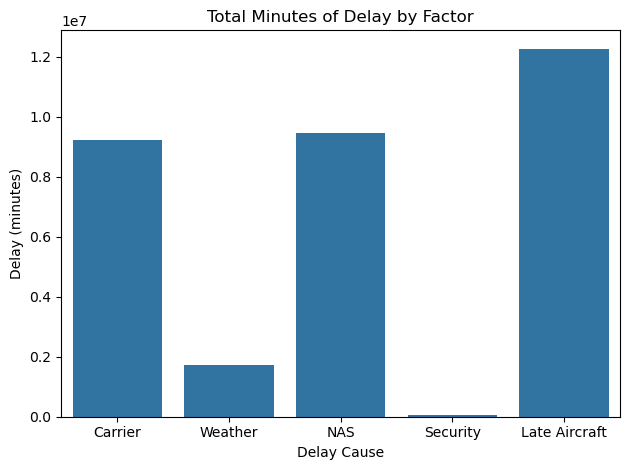

#### **Cancellation Analysis (Task 3)** <a name='task3'></a>

In [ ]:
query = """
CREATE OR REPLACE VIEW cancelled_flights AS
SELECT
  UniqueCarrier,
  Origin,
  Month,
  CancellationCode
FROM `2008`
WHERE Cancelled = 1
"""
cursor.execute(query)

cursor.execute("SELECT UniqueCarrier, COUNT(*) AS cancelled FROM cancelled_flights GROUP BY UniqueCarrier ORDER BY cancelled DESC")
df_airline = pd.DataFrame(cursor.fetchall(), columns=["Airline", "Cancelled Flights"])

cursor.execute("SELECT Origin, COUNT(*) AS cancelled FROM cancelled_flights GROUP BY Origin ORDER BY cancelled DESC LIMIT 10")
df_origin = pd.DataFrame(cursor.fetchall(), columns=["Origin Airport", "Cancelled Flights"])

cursor.execute("SELECT Month, COUNT(*) AS cancelled FROM cancelled_flights GROUP BY Month ORDER BY Month")
df_month = pd.DataFrame(cursor.fetchall(), columns=["Month", "Cancelled Flights"])

sns.barplot(data=df_airline, x="Airline", y="Cancelled Flights")
plt.title("Flight Cancellations by Airline")
plt.ylabel("Cancelled Flights")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.barplot(data=df_origin, x="Origin Airport", y="Cancelled Flights")
plt.title("Top 10 Airports with Most Cancellations")
plt.ylabel("Cancelled Flights")
plt.xlabel("Origin Airport")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_month["MonthName"] = df_month["Month"].map(month_map)

sns.barplot(data=df_month, x="MonthName", y="Cancelled Flights")
plt.title("Cancellations by Month")
plt.ylabel("Cancelled Flights")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

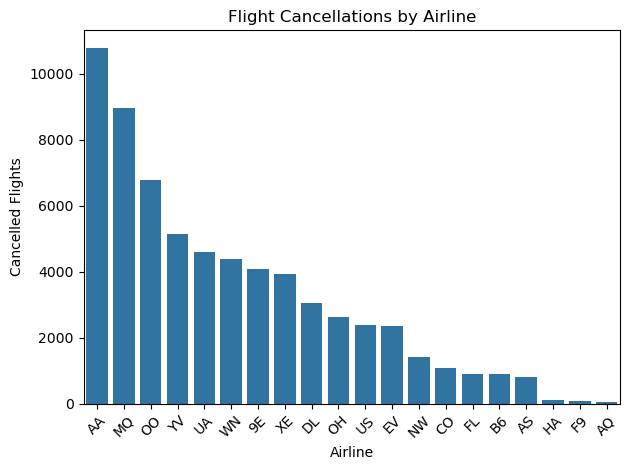

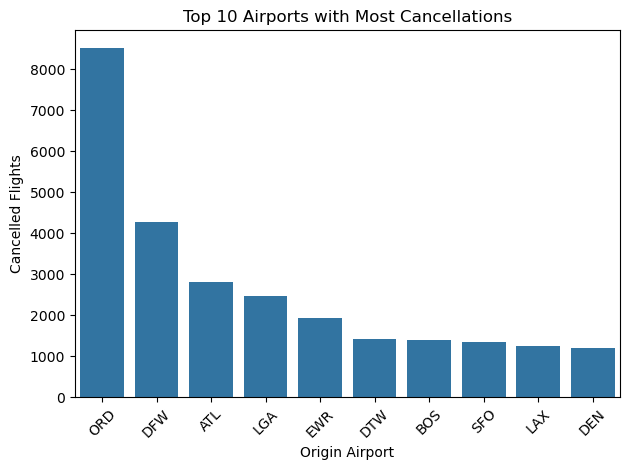

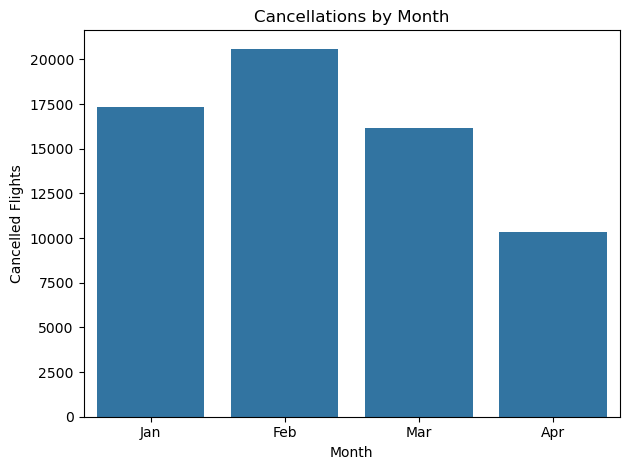

In [ ]:
query = """
SELECT CancellationCode, COUNT(*) AS cancelled_flights
FROM `2008`
WHERE Cancelled = 1
GROUP BY CancellationCode
"""

cursor.execute(query)
df_cancel = pd.DataFrame(cursor.fetchall(), columns=["CancellationCode", "Cancelled Flights"])

cancel_reason_map = {
    "A": "Carrier",
    "B": "Weather",
    "C": "NAS",
    "D": "Security"
}

df_cancel["Reason"] = df_cancel["CancellationCode"].map(cancel_reason_map)

sns.barplot(data=df_cancel, x="Reason", y="Cancelled Flights")
plt.title("Cancelled Flights by Reason")
plt.ylabel("Number of Flights")
plt.xlabel("Cancellation Reason")
plt.tight_layout()
plt.show()

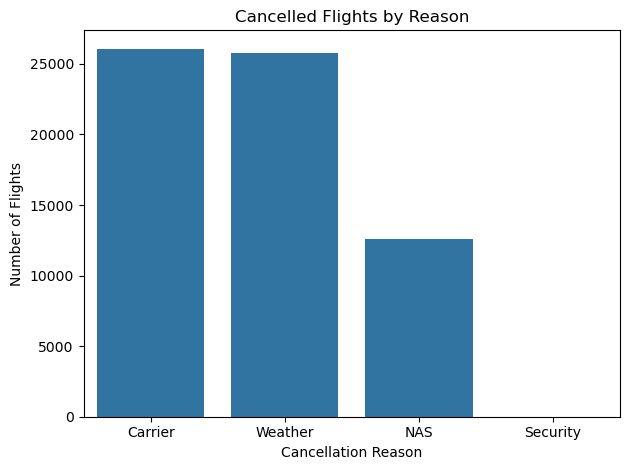

#### **Problematic Routes (Task 4)** <a name='task4'></a>

In [ ]:
query = """
SELECT Origin, Dest, AVG(ArrDelay) AS avg_arrival_delay
FROM `2008`
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY Origin, Dest
HAVING COUNT(*) > 100  -- only consider routes with significant traffic
ORDER BY avg_arrival_delay DESC
LIMIT 10
"""

cursor.execute(query)
df_bad_routes = pd.DataFrame(cursor.fetchall(), columns=["Origin", "Destination", "Avg Arrival Delay"])

query1 = """
SELECT FlightNum, COUNT(*) AS cancellations
FROM `2008`
WHERE Cancelled = 1
GROUP BY FlightNum
ORDER BY cancellations DESC
LIMIT 10
"""

cursor.execute(query1)
df_bad_flights = pd.DataFrame(cursor.fetchall(), columns=["Flight Number", "Cancelled Flights"])

df_bad_routes["Route"] = df_bad_routes["Origin"] + " → " + df_bad_routes["Destination"]

sns.barplot(data=df_bad_routes, x="Route", y="Avg Arrival Delay")
plt.title("Top 10 Routes with Worst Average Arrival Delay")
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("Route")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.barplot(data=df_bad_flights, x="Flight Number", y="Cancelled Flights")
plt.title("Flight Numbers with Most Cancellations")
plt.ylabel("Cancelled Flights")
plt.xlabel("Flight Number")
plt.tight_layout()
plt.show()

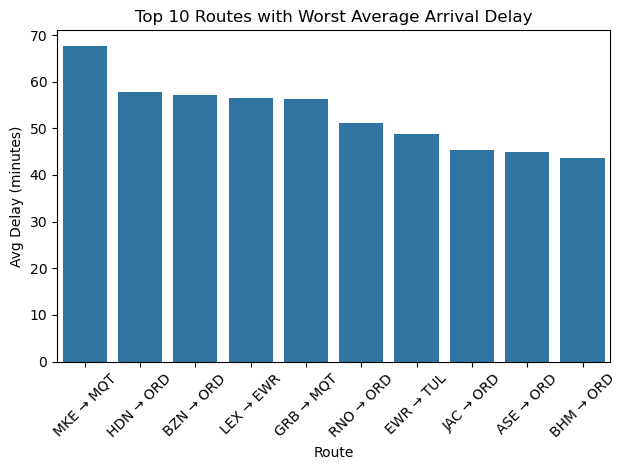

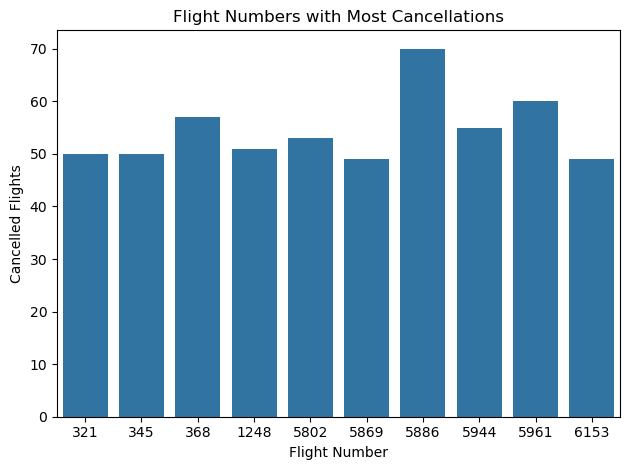

### **Discussion and Finding**<a name='summary'></a>

#### Delay Pattern ####

**1. Delay by Time of Day**

Flights scheduled to depart during the night hours (between 12:00 am and 4:59 am) experienced the lowest average arrival delays. This trend is likely due to minimal air traffic during these hours, resulting in less congestion at both departure and arrival airports. Additionally, since fewer flights are scheduled overnight, the likelihood of cascading delays is reduced. Morning flights also benefit from these conditions to a lesser extent. In contrast, delays steadily increase throughout the day, peaking in the evening. This pattern may be attributed to the cumulative effect of earlier delays in the day, where late arrivals, crew rotations, and aircraft turnaround issues propagate downstream and impact evening flights.


**2. Delay by Day of the Week**

Analysis by day of the week reveals that Friday has the highest average arrival delay. This is likely a result of higher travel volume as both business and leisure travelers converge ahead of the weekend. Increased airport congestion and tightly packed flight schedules on Fridays may further exacerbate delays. In contrast, Wednesday and Saturday exhibit the lowest average delays. Midweek schedules, particularly on Wednesdays, tend to be less congested, while Saturday travel is often less intense compared to Fridays and Sundays, allowing for smoother airport and air traffic operations.

**3. Delay by Month:**

Monthly analysis shows that February had the highest average arrival delays, a result that aligns with expectations due to the prevalence of winter weather conditions in many parts of the United States. Snowstorms, ice, and other winter-related disruptions often lead to flight delays and cancellations. Moreover, de-icing operations and limited daylight hours may contribute to operational slowdowns. On the other hand, April had the lowest average delays, likely reflecting more stable spring weather conditions and lower demand relative to peak travel months such as summer or the winter holidays. This period allows airlines to operate with fewer disruptions and maintain tighter control over their schedules.

#### Delay Factor ####

**Total Delay by Factor**

The data reveals that the largest contributor to total delay time is Late Aircraft, followed closely by NAS (National Airspace System) and Carrier delays. Late Aircraft delays occur when the aircraft's previous flight arrives late, preventing an on-time turnaround. This highlights the interconnected nature of airline schedules, where delays can easily propagate across multiple flights throughout the day. NAS delays, which include air traffic control delays and volume congestion, reflect systemic issues across the airspace system. Carrier delays, caused by factors under the airline’s control such as crew availability or maintenance, also represent a significant share of total delays. In contrast, Weather and Security delays account for a smaller proportion of total delay minutes, suggesting that while they are disruptive, they are less frequent or shorter in duration.


#### Cancellation Analysis ####

**1. Cancelled Flights by Reason**

The majority of flight cancellations were attributed to Carrier-related and Weather-related reasons, which occurred at nearly identical frequencies. Carrier-related cancellations typically involve internal operational issues such as maintenance problems, crew shortages, or overbooking. Weather-related cancellations, on the other hand, are often caused by hazardous flying conditions like snowstorms, thunderstorms, or reduced visibility, especially in the winter months. Cancellations due to NAS (National Airspace System) issues were less frequent, usually related to air traffic control or congestion. Security-related cancellations were extremely rare, indicating that while security delays can occur, they almost never result in outright flight cancellations.

**2. Cancellations by Airline**

American Airlines (AA) recorded the highest number of cancellations, followed closely by American Eagle (MQ) and SkyWest (OO). These airlines likely operate high flight volumes, especially in major hubs affected by weather or operational constraints, which increases their exposure to disruptions. Regional carriers like MQ and OO are often more vulnerable to cascading delays or aircraft unavailability due to limited fleet flexibility. Carriers with fewer cancellations are generally smaller or operate in regions with more stable weather and less congested airspace.

**3. Cancellations by Airport:**

Chicago O’Hare International Airport (ORD) experienced the highest number of cancellations, significantly more than any other airport. This is not surprising given its location in the Midwest, where winter weather conditions can be severe, combined with its role as a major connecting hub. Dallas/Fort Worth (DFW) and Atlanta (ATL) also reported high cancellation volumes, reflecting their heavy traffic loads. Other highly affected airports include LaGuardia (LGA), Newark (EWR), and Detroit (DTW), all located in regions known for seasonal weather volatility and airspace congestion.

**3. Cancellations by Month:**

February recorded the highest number of cancellations, reinforcing the impact of winter weather on flight operations. January and March also showed elevated cancellation counts, consistent with the same seasonal pattern. April, in contrast, had noticeably fewer cancellations, likely due to improved weather conditions and more stable air traffic environments during the early spring. This monthly trend highlights how external factors such as climate and seasonality can significantly influence airline reliability.

#### Problematic Routes ####

**Worst Performing Routes**

Among the routes with the highest average arrival delays, the most severely impacted was Milwaukee (MKE) to Marquette (MQT), with an average delay approaching 70 minutes. Several other problematic routes included HDN → ORD, BZN → ORD, and LEX → EWR. A common thread among these routes is their connection to major hub airports such as Chicago O’Hare (ORD) and Newark Liberty (EWR), both of which are known for frequent congestion, weather-related delays, and high operational volume. Furthermore, routes involving smaller or regional airports such as MQT or GRB may have limited aircraft availability and fewer flight options, making them more vulnerable to schedule disruptions when delays occur upstream.


**Flight Numbers with Most Cancellations**

The flight number 5886 had the most cancellations, followed by others such as 5961, 368, and 5944. While flight numbers alone don’t specify origin-destination pairs, a high frequency of cancellations could indicate specific time slots, routes, or operational patterns that are prone to disruption. These may be flights scheduled during peak traffic periods, highly weather-sensitive legs, or flights repeatedly impacted by aircraft rotation delays. Identifying these patterns is important for optimizing flight schedules and allocating contingency resources.


### **Conclusion**<a name='conclusion'></a>

This project provided a comprehensive analysis of airline on-time performance in the United States using the 2008 dataset. Through the integration of Hive for large-scale querying and Python for data visualization, we were able to extract, interpret, and present operational insights across four key focus areas: delay patterns, delay factors, cancellation analysis, and problematic flight routes. The findings offer a clear reflection of the operational dynamics within the aviation sector and reveal opportunities for strategic improvement.

**1. Summary of Key Findings**

Our investigation into delay patterns revealed that flights departing in the early morning or late at night consistently experience lower average delays. Delays intensify toward the afternoon and evening, likely due to cascading effects from earlier disruptions. Moreover, Wednesdays and Saturdays demonstrated superior punctuality, while Fridays showed the worst performance—likely a result of peak travel volume and congested schedules. February was the most delay-prone month, indicating seasonal vulnerabilities, particularly due to winter weather.

When evaluating delay causes, Late Aircraft and NAS-related delays (e.g., airspace congestion or air traffic control issues) were found to be the most significant contributors to total delay minutes. These two categories alone accounted for the majority of delays, underscoring the interconnectedness of flights and the impact of system-wide bottlenecks. In contrast, weather and security delays, while operationally significant, contributed less to total delay duration but were more prominent in cancellation scenarios.

The cancellation analysis confirmed that Carrier and Weather were the most frequent reasons for flight cancellations, each contributing nearly equally. Airlines such as American Airlines (AA) and American Eagle (MQ) experienced the highest absolute number of cancellations, and Chicago O’Hare (ORD) had the most cancellations of any airport. Cancellations also peaked in February, echoing the seasonal weather challenges identified in the delay analysis.

In the examination of problematic routes, flights connecting smaller regional airports to major hubs—such as MKE → MQT and BZN → ORD—emerged as the worst performers in terms of average delay. These routes are particularly sensitive to schedule disruptions and may lack operational redundancy. Additionally, several flight numbers showed disproportionately high cancellation rates, suggesting recurring issues that may relate to aircraft assignment, crew availability, or scheduling inefficiencies.

**2. Practical Recommendations**

Based on the findings above, several actionable strategies are proposed to enhance operational performance and passenger reliability:

1. **Prioritize Operational Buffers for Late-Day Flights**

  Since delays accumulate throughout the day, airlines should consider adding buffer time between rotations for afternoon and evening flights. This could mitigate the impact of earlier delays, reduce misconnects, and improve schedule reliability.

2. **Weather-Responsive Resource Planning**

  Given the sharp increase in cancellations during February and January, airports and carriers operating in weather-sensitive regions should pre-position resources (e.g., de-icing units, standby crews) during winter months. Dynamic schedule adjustments, including proactive flight cancellations with rebooking windows, could prevent cascading disruptions.

3. **Address Systemic NAS Bottlenecks**

  With NAS-related delays ranking among the highest, coordination with the Federal Aviation Administration (FAA) and enhanced airspace optimization technologies (such as real-time flow management systems) should be explored to alleviate congestion during peak periods.

4. **Route-Level Reliability Reviews**
  
  Problematic origin–destination pairs should be reviewed regularly using delay performance metrics. Routes consistently affected by turnaround issues or hub congestion could benefit from reallocation of more reliable aircraft, dedicated recovery slots, or revised departure schedules.

5. **Focus on Flight Number-Specific Issues**
  
  Flight numbers with a high number of cancellations may indicate systemic scheduling conflicts or insufficient operational slack. These flights should be prioritized for root cause analysis and potential rescheduling, especially if they fall into busy time slots or are part of tight rotation plans.

6. **Improve Passenger Communication and Contingency Planning**

  From a service quality perspective, both delays and cancellations must be paired with improved passenger handling. This includes timely rebooking, automated delay notifications, and real-time updates via mobile apps and terminals to reduce customer dissatisfaction.

While this study focused on 2008 data, future extensions could explore multi-year comparisons to assess whether systemic issues persist over time or vary with policy and infrastructure changes. Integrating weather data, airport capacity statistics, and aircraft maintenance logs would further enrich the analysis and support predictive modeling. Moreover, employing machine learning techniques on a distributed processing platform like Spark could offer real-time risk assessment for delay and cancellation likelihood.

This project demonstrates the practical utility of big data tools in making sense of complex, high-volume airline performance data. The combination of Hive and Python enabled us to not only process millions of records efficiently but also to translate raw data into actionable intelligence. As airline networks become increasingly complex and passenger expectations continue to rise, such analytical frameworks are essential for driving operational resilience and strategic agility. Ultimately, this work reinforces the role of data-driven decision-making in shaping the future of air travel.